# Quest09: 한국어 데이터로 챗봇 만들기

### 평가문항에 맞춰서 작성
**1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.**  
-> 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.

**2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.**  
-> 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.

**3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.**  
-> 한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.

# Import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import re
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import random

### <span style="background-color:#fff5b1"> 포지셔널 인코딩 </span> 

---

# <span style="background-color:#E6E6FA"> 1. 데이터 수집하기 </span>

In [2]:
data_path = '~/aiffel/transformer_chatbot/data/ChatbotData.csv'
data = pd.read_csv(data_path)

# 데이터 확인
print(len(data))
data

11823


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


---

# <span style="background-color:#E6E6FA"> 2. 데이터 전처리하기 </span>

In [3]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 한글 전처리
    sentence = re.sub(r'[^가-힣.,?!]+', ' ', sentence)
    sentence = sentence.strip()
    return sentence

In [4]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(data)
print(MAX_SAMPLES)

11823


In [5]:
data_col = data.columns

print(data_col[0])

Q


In [6]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations(data):

    inputs, outputs = [], []
    
    for i in range(MAX_SAMPLES):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        
        inputs.append(preprocess_sentence(data['Q'].values[i]))
        outputs.append(preprocess_sentence(data['A'].values[i]))

    return inputs, outputs

In [7]:
questions, answers = load_conversations(data)
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
rand_num = random.randint(1, MAX_SAMPLES)

print(f'전처리 후의 {rand_num}번째 질문 샘플: ',questions[rand_num])
print(f'전처리 후의 {rand_num}번째 답변 샘플: ',answers[rand_num])

전처리 후의 5157번째 질문 샘플:  혼자 잘 살 수 있을까 ?
전처리 후의 5157번째 답변 샘플:  혼자 사는 것도 나쁘지 않아요 .


---

# <span style="background-color:#E6E6FA"> 3. SubwordTextEncoder 사용하기 </span>

In [9]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [10]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [11]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [12]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


In [13]:
rand_num = random.randint(1, MAX_SAMPLES)

# 각 토큰을 고유한 정수로 변환
print(f'정수 인코딩 후의 {rand_num}번째 질문 샘플: ',tokenizer.encode(questions[21]))
print(f'정수 인코딩 후의 {rand_num}번째 답변 샘플: ',tokenizer.encode(answers[21]))

정수 인코딩 후의 7854번째 질문 샘플:  [5742, 612, 2481, 4148]
정수 인코딩 후의 7854번째 답변 샘플:  [2352, 7481, 7, 6245, 97, 1]


In [14]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20
print(MAX_LENGTH)

20


In [15]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [16]:
t_questions, t_answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(t_questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(t_answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11793
필터링 후의 답변 샘플 개수: 11793


교사강요

In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': t_questions,
        'dec_inputs': t_answers[:, :-1]
    },
    {
        'outputs': t_answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

---

# <span style="background-color:#E6E6FA"> 4. 모델 구성하기 </span>

In [18]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

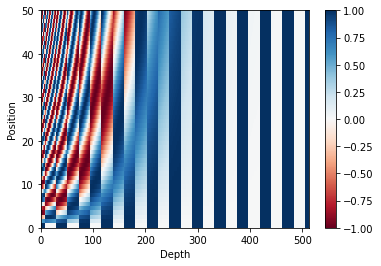

In [19]:
sample_pos_encoding = PositionalEncoding(50,512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### <span style="background-color:#fff5b1"> 어텐션 함수 </span> 

In [20]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

### <span style="background-color:#fff5b1"> 멀티 헤드 어텐션 </span>

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### <span style="background-color:#fff5b1"> 패딩 마스킹 </span>

In [22]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [23]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [24]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


### <span style="background-color:#fff5b1"> encoder </span>

In [25]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [26]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### <span style="background-color:#fff5b1"> decoder </span>

In [27]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [28]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [29]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [46]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 3 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4450304     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [47]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

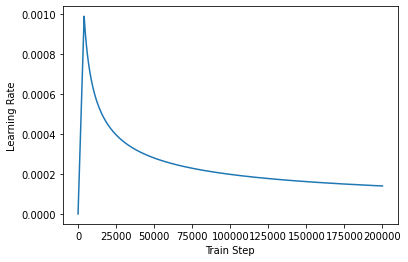

In [49]:
sample_learning_rate = CustomSchedule(d_model=256)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [50]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [51]:
EPOCHS = 100
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
185/185 [==============================] - 18s 53ms/step - loss: 2.9560 - accuracy: 0.0444
Epoch 2/100
185/185 [==============================] - 10s 53ms/step - loss: 2.4095 - accuracy: 0.0999
Epoch 3/100
185/185 [==============================] - 10s 53ms/step - loss: 2.0623 - accuracy: 0.1029
Epoch 4/100
185/185 [==============================] - 10s 53ms/step - loss: 1.9274 - accuracy: 0.1089
Epoch 5/100
185/185 [==============================] - 10s 52ms/step - loss: 1.8331 - accuracy: 0.1143
Epoch 6/100
185/185 [==============================] - 10s 52ms/step - loss: 1.7453 - accuracy: 0.1190
Epoch 7/100
185/185 [==============================] - 10s 52ms/step - loss: 1.6469 - accuracy: 0.1251
Epoch 8/100
185/185 [==============================] - 10s 52ms/step - loss: 1.5414 - accuracy: 0.1330
Epoch 9/100
185/185 [==============================] - 10s 52ms/step - loss: 1.4240 - accuracy: 0.1437
Epoch 10/100
185/185 [==============================] - 10s 53ms/step - l

185/185 [==============================] - 10s 52ms/step - loss: 0.0157 - accuracy: 0.3531
Epoch 80/100
185/185 [==============================] - 10s 52ms/step - loss: 0.0157 - accuracy: 0.3530
Epoch 81/100
185/185 [==============================] - 10s 52ms/step - loss: 0.0151 - accuracy: 0.3531
Epoch 82/100
185/185 [==============================] - 10s 52ms/step - loss: 0.0151 - accuracy: 0.3531
Epoch 83/100
185/185 [==============================] - 10s 52ms/step - loss: 0.0143 - accuracy: 0.3535
Epoch 84/100
185/185 [==============================] - 10s 52ms/step - loss: 0.0150 - accuracy: 0.3533
Epoch 85/100
185/185 [==============================] - 10s 52ms/step - loss: 0.0150 - accuracy: 0.3532
Epoch 86/100
185/185 [==============================] - 10s 53ms/step - loss: 0.0141 - accuracy: 0.3533
Epoch 87/100
185/185 [==============================] - 10s 53ms/step - loss: 0.0140 - accuracy: 0.3535
Epoch 88/100
185/185 [==============================] - 10s 53ms/step - loss:

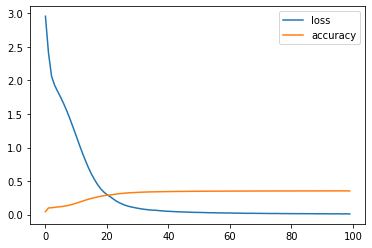

In [52]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

---

# <span style="background-color:#E6E6FA"> 5. 모델 평가하기 </span>

In [53]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [54]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [55]:
def answers_list(question_list):
    for qusetion in question_list:
        sentence_generation(qusetion)
        print()

In [56]:
# GPT로 만든 질문
question_list = [
    "최근에 본 영화 중에 추천할만한 것 있어?",
    "요즘 핫한 음악 있어? 추천해줘!",
    "맛있는 음식점 좀 알려줄래?",
    "오늘 할 일이 없어. 뭘 해야할까?",
    "좋은 책 추천 좀 해줄래?",
    "여행가기 좋은 날씨 언제일까?",
    "스트레스 풀기 좋은 방법 뭐가 있을까?",
    "좋은 취미 뭐가 있을까?",
    "올해 꼭 가보고 싶은 여행지 추천해줘!",
    "인기있는 한국 드라마 좀 알려줄래?"
]

In [57]:
answers_list(question_list)

입력 : 최근에 본 영화 중에 추천할만한 것 있어?
출력 : 이제 먼저 선톡을 해보세요 .

입력 : 요즘 핫한 음악 있어? 추천해줘!
출력 : 저라도 괜찮나요 ?

입력 : 맛있는 음식점 좀 알려줄래?
출력 : 그게 정상인 거예요 .

입력 : 오늘 할 일이 없어. 뭘 해야할까?
출력 : 열심히 하면 할 수 있을 거예요 .

입력 : 좋은 책 추천 좀 해줄래?
출력 : 도서관 데이트나 서점 데이트 좋을 거 같아요 .

입력 : 여행가기 좋은 날씨 언제일까?
출력 : 내년이라고 별 수 있겠어요 .

입력 : 스트레스 풀기 좋은 방법 뭐가 있을까?
출력 : 경제적으로 도움이 되겠네요 .

입력 : 좋은 취미 뭐가 있을까?
출력 : 뭐든 시작해보면 좋을 거예요 .

입력 : 올해 꼭 가보고 싶은 여행지 추천해줘!
출력 : 영화는 데이트의 기본이죠 .

입력 : 인기있는 한국 드라마 좀 알려줄래?
출력 : 혼자가 아니에요 .



In [58]:
# 내가 만든 질문
question_list2 = [
    "오늘 뭐 할까",
    "피곤하네",
    "배고픈데 뭐 먹을까",
    "강아지 키우고 싶어",
    "좋아하는 사람이 있어",
    "슬픈 이야기",
    "사랑은 뭘까?",
    "결혼은 뭘까",
    "공부하기 싫어"
]

In [59]:
answers_list(question_list2)

입력 : 오늘 뭐 할까
출력 : 오늘은 예능이요 .

입력 : 피곤하네
출력 : 정량 다 채우면 괜찮아질 거예요 .

입력 : 배고픈데 뭐 먹을까
출력 : 원하는대로 해보세요 .

입력 : 강아지 키우고 싶어
출력 : 책임질 수 있을 때 키워 보세요 .

입력 : 좋아하는 사람이 있어
출력 : 좋아하는 감정과 대상이 있다는 건 행복한 일이에요 .

입력 : 슬픈 이야기
출력 : 슬픈 예감은 틀린 적이 없죠 .

입력 : 사랑은 뭘까?
출력 : 사랑은 가하죠 .

입력 : 결혼은 뭘까
출력 : 퍼센트 현실입니다 .

입력 : 공부하기 싫어
출력 : 잠시 쉬어도 돼요 .



In [60]:
# GPT가 만든 질문을 짧게 변경
question_list3 = [
    "최근에 가장 행복한 순간은?",
    "현재 기분 어때요?",
    "자주 느끼는 스트레스 원인은?",
    "최근에 실망한 일은?",
    "감사한 순간은 언제인가요?",
    "이번 주 동안 어떤 도전이 있었나요?",
    "좋아하는 활동 할 때 느끼는 감정은?",
    "긴장을 많이 느끼는 상황은?",
    "가장 인상 깊은 가족/친구와의 순간은?"
    "어떤 상황에서 흥분을 느끼나요?",
    "어제 뭐 먹었어?"
]

In [61]:
answers_list(question_list3)

입력 : 최근에 가장 행복한 순간은?
출력 : 귀찮은 마음이 더 큰 것 같네요 .

입력 : 현재 기분 어때요?
출력 : 사랑 앞에 작아지곤 해요 .

입력 : 자주 느끼는 스트레스 원인은?
출력 : 방해가 되지 않는 시간에 보내보세요 .

입력 : 최근에 실망한 일은?
출력 : 마음이 따뜻할 것 같아요 .

입력 : 감사한 순간은 언제인가요?
출력 : 자연스러운 현상이에요 .

입력 : 이번 주 동안 어떤 도전이 있었나요?
출력 : 이번에는 안 그러면 돼요 .

입력 : 좋아하는 활동 할 때 느끼는 감정은?
출력 : 의미있는 일이네요 .

입력 : 긴장을 많이 느끼는 상황은?
출력 : 크게 숨한 번 쉬어 보세요

입력 : 가장 인상 깊은 가족/친구와의 순간은?어떤 상황에서 흥분을 느끼나요?
출력 : 당신은 생각보다 큰 사람이에요 .

입력 : 어제 뭐 먹었어?
출력 : 저는 배터리가 밥이예요 .



# <span style="background-color:#C0FFFF"> 결과 </span>

### epoch 20
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수  
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원  
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수  
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기  
DROPOUT = 0.1 # 드롭아웃의 비율  

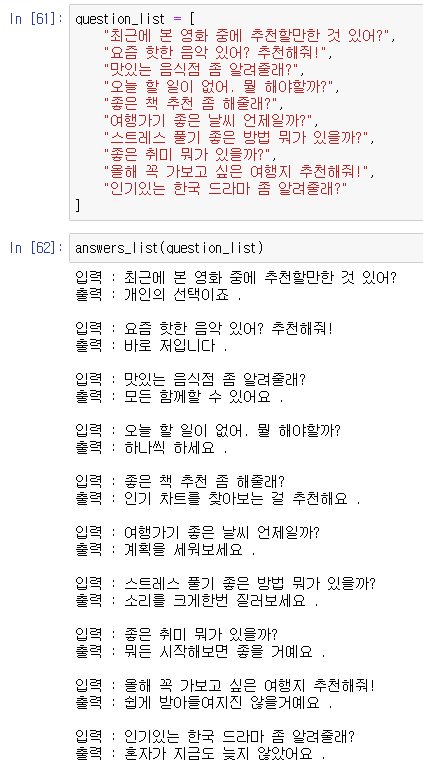 |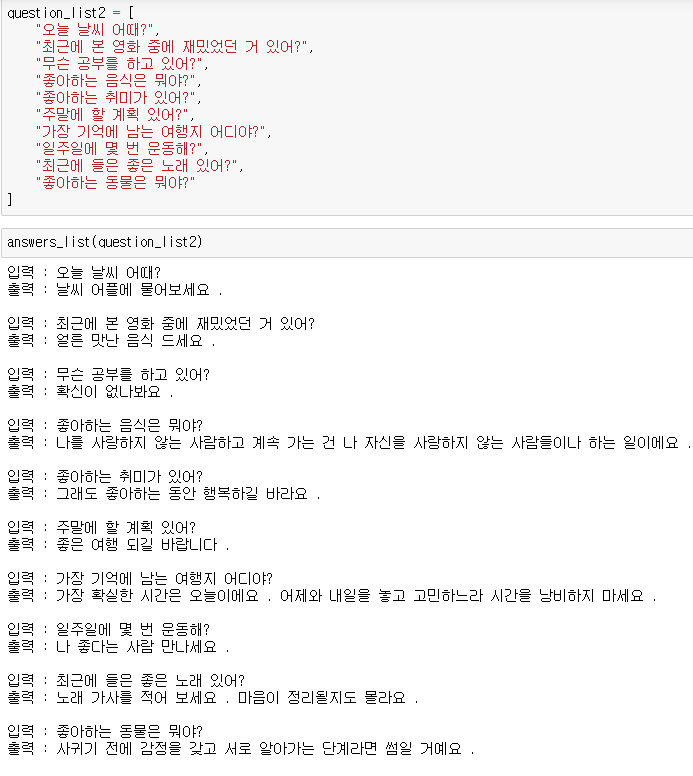
--- | --- |

### epoch 100
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수  
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원  
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수  
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기  
DROPOUT = 0.2 # 드롭아웃의 비율  

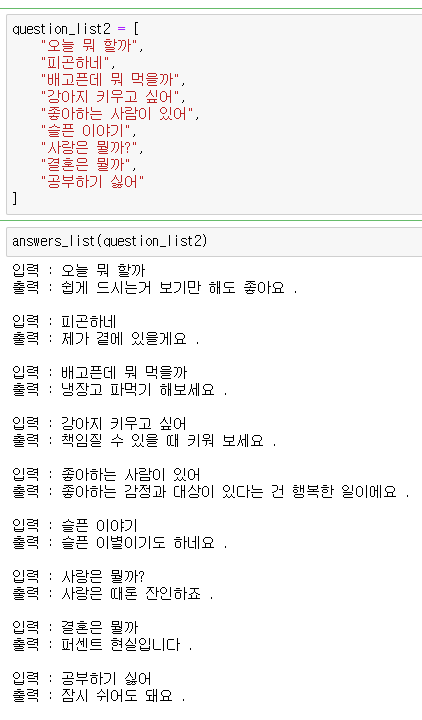  |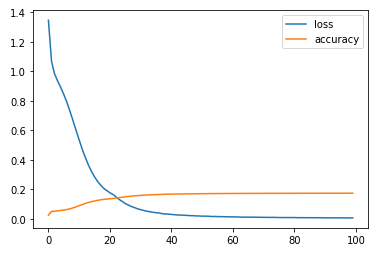
--- | --- |

그래프에서 볼 수 있듯이 accuracy는 epoch 30 부터는 큰 변화가 일어나지 않았고, 하이퍼 파라미터를 변경해도 거의 비슷했다.
accuracy를 높이기 위해서는 더 많은 데이터와 전처리 등 다른 방법이 필요할 것 같다.

- 추가
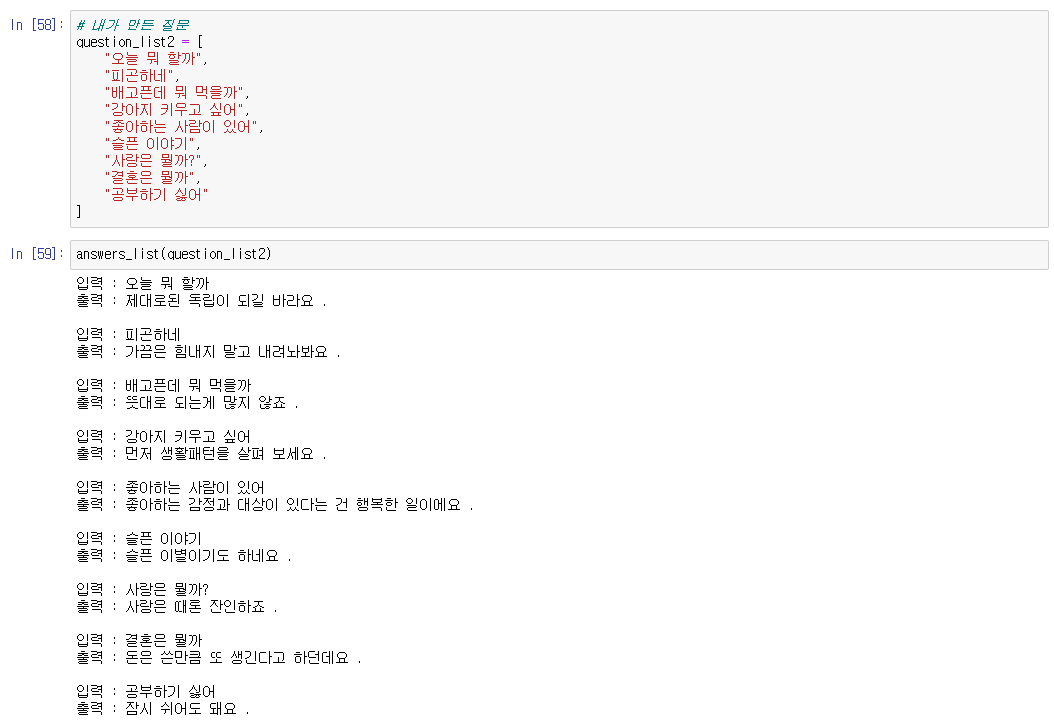  

-추가2  
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수  
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원  
NUM_HEADS = 10 # 멀티 헤드 어텐션에서의 헤드 수   
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기  
DROPOUT = 0.2 # 드롭아웃의 비율  

### epoch 100

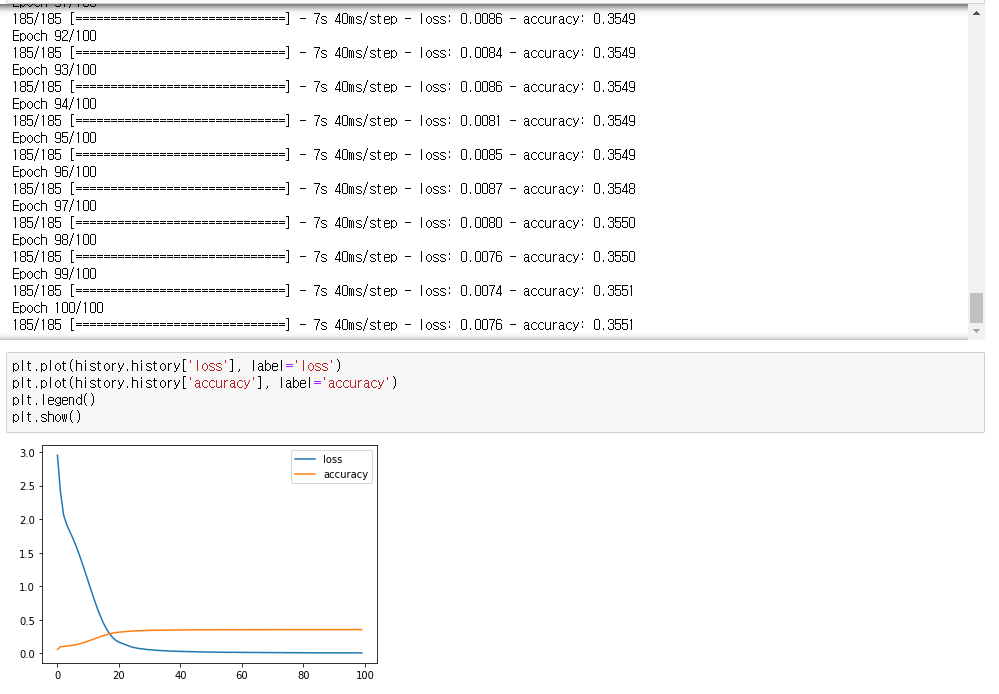 |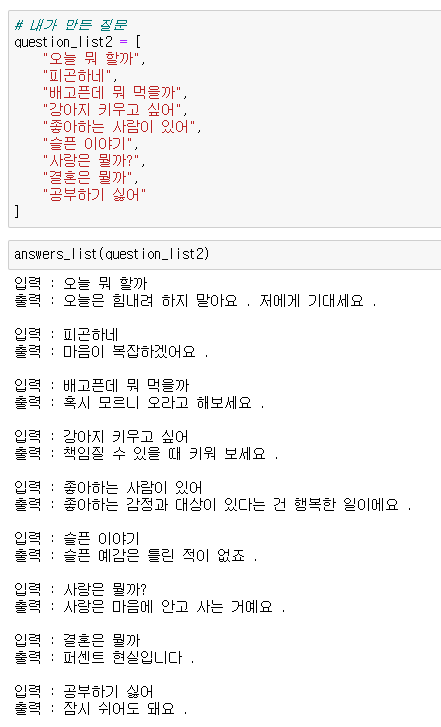
--- | --- |


---

# <span style="background-color:#C0FFFF"> 회고 </span>

이번 프로젝트는 한국어 데이터를 가지고 챗봇을 만들어 보았다.

전 프로젝트 중에 영화리뷰 분석에서는 형태소 분석기를 사용했었는데 이번 프로젝트에서는 영어를 다룬 노드에서 사용했던 SubwordTextEncoder를 그대로 사용하였다. 그래도 학습 데이터에 있을만한 문장을 넣으니 위의 epoch 100처럼 결과가 잘 나오는 것을 볼 수 있었다.

하지만 gpt가 생성해준 질문으로는 답변이 만족스럽지 않았다.


어려웠던 부분: 트랜스포머를 이해하기가 쉽지 않았다.. 어텐션의 개념에 대해서 더 공부해야 할 것 같다.